# Temperature Data
This data is included with the git repository. The data is available for NSW, Victoria, SA and Queensland. I've done the discovery for NSW data however we'll use all the states in the model to get a representative result for Australia.

In [1]:
import pandas as pd
import seaborn as sns
from datetime import datetime
df_states = [pd.read_csv(f'~/PycharmProjects/ZZSC9020-Group-M/data/Australia/temperature_{s}.csv') for s in ['nsw', 'vic', 'qld', 'sa']]
df = pd.concat(df_states)
df.columns = [c.lower() for c in df.columns]

# Dates are in mixed format
def parse_date(value: str):
    try:
        result = datetime.strptime(value, '%d/%m/%Y %H:%M')
    except ValueError:
        result = datetime.strptime(value, '%Y-%m-%d %H:%M:%S')
    return result

df['datetime'] = df['datetime'].apply(parse_date)
df

,location,datetime,temperature,unnamed: 0
0,Bankstown,2010-01-01 00:00:00,23.1,NaN
1,Bankstown,2010-01-01 00:01:00,23.1,NaN
2,Bankstown,2010-01-01 00:30:00,22.9,NaN
3,Bankstown,2010-01-01 00:50:00,22.7,NaN
4,Bankstown,2010-01-01 01:00:00,22.6,NaN
...,...,...,...,...
208080,Adelaide (Kent Town),2021-03-17 22:00:00,19.6,208080.0
208081,Adelaide (Kent Town),2021-03-17 22:30:00,19.5,208081.0
208082,Adelaide (Kent Town),2021-03-17 23:00:00,19.4,208082.0
208083,Adelaide (Kent Town),2021-03-17 23:30:00,19.6,208083.0


In [2]:
# Clean up the extra column in the SA dataset
df = df[['location', 'datetime', 'temperature']]
df.groupby('location').count()

,datetime,temperature
location,,
Adelaide (Kent Town),208085,208085
Bankstown,220326,220326
Brisbane Archerfield Airport,208085,208085
Melbourne (Olympic Park),141681,141681


In [3]:
from datetime import datetime
def trunc_month(value: datetime):
    return datetime(value.year, value.month, 1)

def trunc_quarter(value: datetime):
    return datetime(value.year, (value.month - 1) // 3 * 3 + 1, 1)

df['date'] = df.apply(lambda x: x['datetime'].date(), axis=1)
df['month'] = df['datetime'].apply(trunc_month)
df['quarter'] = df['datetime'].apply(trunc_quarter)
df

,location,datetime,temperature,date,month,quarter
0,Bankstown,2010-01-01 00:00:00,23.1,2010-01-01,2010-01-01,2010-01-01
1,Bankstown,2010-01-01 00:01:00,23.1,2010-01-01,2010-01-01,2010-01-01
2,Bankstown,2010-01-01 00:30:00,22.9,2010-01-01,2010-01-01,2010-01-01
3,Bankstown,2010-01-01 00:50:00,22.7,2010-01-01,2010-01-01,2010-01-01
4,Bankstown,2010-01-01 01:00:00,22.6,2010-01-01,2010-01-01,2010-01-01
...,...,...,...,...,...,...
208080,Adelaide (Kent Town),2021-03-17 22:00:00,19.6,2021-03-17,2021-03-01,2021-01-01
208081,Adelaide (Kent Town),2021-03-17 22:30:00,19.5,2021-03-17,2021-03-01,2021-01-01
208082,Adelaide (Kent Town),2021-03-17 23:00:00,19.4,2021-03-17,2021-03-01,2021-01-01
208083,Adelaide (Kent Town),2021-03-17 23:30:00,19.6,2021-03-17,2021-03-01,2021-01-01


## Maximum and Minimum
These are the maximum and minimum temperatures in each quarter. These are not representative of the quarter because they represent a single day of extreme temperature.

<Axes: xlabel='quarter', ylabel='temperature'>

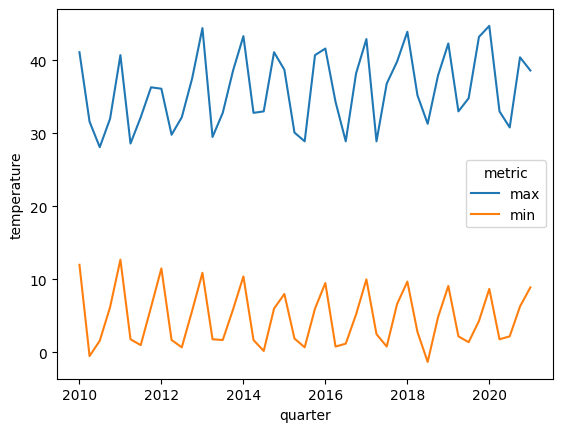

In [4]:
df_max = df[['quarter', 'temperature']].groupby('quarter').max()
df_max['metric'] = 'max'
df_min = df[['quarter', 'temperature']].groupby('quarter').min()
df_min['metric'] = 'min'

df_quarter = pd.concat([df_max, df_min], axis=0)
# df_quarter
sns.lineplot(data=df_quarter, x='quarter', y='temperature', hue='metric')

## Maximum and Minimum Monthly Average
These numbers represent the maximum average monthly temperature for each quarter.
The process for deriving these is:
1. Get the min, max, and mean temperature for each day.
2. Get the monthly averages of the daily min, max and mean.
3. For each quarter:
    - Get the smallest minimum monthly temperature.
    - Get the largest maximum monthly temperature.
    - Get the mean of the mean temperatures of the months.

<Axes: xlabel='quarter', ylabel='temperature'>

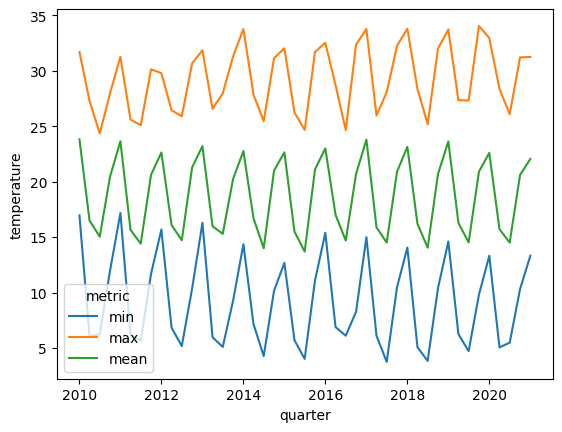

In [5]:
df_day = df.groupby(['date', 'month', 'quarter']).agg({'temperature': ['min', 'max', 'mean']})
# df_day
df_month = df_day.groupby(['month', 'quarter']).mean() # .agg({'min': 'mean', 'max': 'mean'})
df_month.columns = df_month.columns.droplevel()
# df_month
df_quarter = df_month.groupby('quarter').agg({'min': 'min', 'max': 'max', 'mean': 'mean'})
df_quarter = df_quarter.stack().to_frame().reset_index()
df_quarter.columns = ['quarter', 'metric', 'temperature']
# df_max = df[['quarter', 'temperature']].groupby('quarter').max()
# df_max['metric'] = 'max'
# df_min = df[['quarter', 'temperature']].groupby('quarter').min()
# df_min['metric'] = 'min'

# df_quarter = pd.concat([df_max, df_min], axis=0)
df_quarter
sns.lineplot(data=df_quarter, x='quarter', y='temperature', hue='metric')

## Maximum and Minimum Monthly Average by State
These numbers represent the maximum average monthly temperature for each quarter.
The process for deriving these is:
1. Get the min, max, and mean temperature for each day for each location.
2. Get the monthly averages of the daily min, max and mean for each location.
3. For each quarter get the mean of the minimum, average and maximum temperatures.

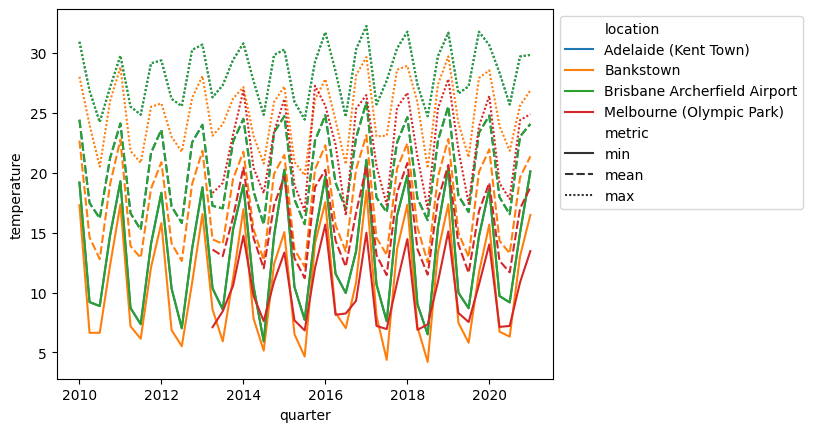

In [6]:
df_day = df.groupby(['location', 'date', 'month', 'quarter']).agg({'temperature': ['min', 'max', 'mean']})
# df_day
df_month = df_day.groupby(['location', 'month', 'quarter']).mean() # .agg({'min': 'mean', 'max': 'mean'})
df_month.columns = df_month.columns.droplevel()
# df_month
# df_max = df[['quarter', 'temperature']].groupby('quarter').max()
# df_max['metric'] = 'max'
# df_min = df[['quarter', 'temperature']].groupby('quarter').min()
# df_min['metric'] = 'min'

# df_quarter = pd.concat([df_max, df_min], axis=0)
df_quarter = df_month.groupby(['location', 'quarter']).agg({'min': 'min', 'mean': 'mean', 'max': 'max'}).stack().reset_index()
df_quarter.columns = ['location', 'quarter', 'metric', 'temperature']
df_quarter
ax = sns.lineplot(data=df_quarter, x='quarter', y='temperature', hue='location', style='metric')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Data issues
- South Australia data had extra column which needed to be removed.
- We don't have data for Victoria before 2013. This won't make much impact since we're taking the mean. If we were taking the sum this would be an issue.

In [7]:
df_quarter

,location,quarter,metric,temperature
0,Adelaide (Kent Town),2010-01-01,min,19.167742
1,Adelaide (Kent Town),2010-01-01,mean,24.412255
2,Adelaide (Kent Town),2010-01-01,max,30.912903
3,Adelaide (Kent Town),2010-04-01,min,9.203333
4,Adelaide (Kent Town),2010-04-01,mean,17.475016
...,...,...,...,...
496,Melbourne (Olympic Park),2020-10-01,mean,17.005087
497,Melbourne (Olympic Park),2020-10-01,max,24.383333
498,Melbourne (Olympic Park),2021-01-01,min,13.455556
499,Melbourne (Olympic Park),2021-01-01,mean,18.765917


In [12]:
df_combined_quarter = df_quarter.groupby(['quarter', 'metric']).mean(numeric_only=True).reset_index().pivot(index='quarter', columns='metric', values='temperature').reset_index()
# df_combined_quarter = df_combined_quarter.stack().to_frame().reset_index()
df_combined_quarter.columns = ['quarter', 'max_temperature', 'average_temperature', 'min_temperature']
df_combined_quarter
# sns.lineplot(data=df_combined_quarter, x='quarter', y='temperature', hue='metric')

,quarter,max_temperature,average_temperature,min_temperature
0,2010-01-01,29.941935,23.834218,18.540860
1,2010-04-01,25.884444,16.519563,8.348889
2,2010-07-01,22.975556,15.057836,8.130108
3,2010-10-01,26.725806,20.491817,13.936559
4,2011-01-01,29.438095,23.652416,18.634409
5,2011-04-01,24.272222,15.706545,8.203333
6,2011-07-01,23.496667,14.457767,6.955914
7,2011-10-01,27.908889,20.656134,13.420430
8,2012-01-01,28.162736,22.674850,17.478495
9,2012-04-01,25.098889,16.147244,9.177778


In [13]:
# df_output = df_combined_quarter.pivot(index='quarter', columns='metric', values='temperature').reset_index()
# df_output = df_combined_quarter[['quarter', 'min', 'max']]
df_combined_quarter.to_csv('../data/transformed/temperature.csv', index=False)